# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.

## General Rules

Please check all the requirements listed on Canvas, but here are some general rules:

- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name: Liviu-Daniel Florescu**  
**Neptun ID: F06DLV**

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines

Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.


# 0. Necessary Imports

Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**


In [1]:
# ADD YOUR CODE HERE
import torch
import torchvision.transforms.v2 as transforms

import torchtext
from torch.utils.data import Dataset, DataLoader

# 1. DATASET

For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.


### 1.1. Download dataset

The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235


### 1.2. Load dataset

In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.


In [48]:
from collections import Counter, OrderedDict
import csv
import os
from typing import List
from torch.utils.data import random_split

from matplotlib import pyplot as plt

IMAGES_DIR = "dataset/Images"
CAPTIONS_FILE_PATH = "dataset/captions.txt"

PAD = "<pad>"
UNK = "<unk>"
SOS = "<sos>"
EOS = "<eos>"
VOCAB_SPECIALS = [PAD, UNK, SOS, EOS]


def read_captions(captions_path) -> dict:
    img_name_to_captions = dict()

    with open(captions_path, "r") as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        for row in reader:
            img_name, caption = row
            caption = caption.lower()

            img_name_to_captions.setdefault(img_name, [])
            img_name_to_captions[img_name].append(caption)

    return img_name_to_captions


def create_vocabulary(captions, min_freq) -> torchtext.vocab.Vocab:
    raw_tokens = [t for caption in captions for t in caption.split(" ")]
    print("Raw token count:", len(raw_tokens))

    counter = Counter(raw_tokens)
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    vocab = torchtext.vocab.vocab(
        OrderedDict(sorted_by_freq_tuples), min_freq=min_freq, specials=VOCAB_SPECIALS
    )
    vocab.set_default_index(vocab[UNK])

    print(f"Created vocabulary with {len(vocab.get_itos())} tokens.")

    return vocab


def tokenize_captions(vocab, captions):
    def tokenize_caption(caption):
        tokens = [vocab[token] for token in caption.split(" ")]
        return [vocab[SOS]] + tokens + [vocab[EOS]]

    return [tokenize_caption(caption) for caption in captions]


def filter_img_caption_dict(img_caption_dict, wanted_images):
    return {img: list(img_caption_dict[img]) for img in wanted_images}


img_name_to_captions = read_captions(CAPTIONS_FILE_PATH)
all_captions = [
    caption
    for img_captions in img_name_to_captions.values()
    for caption in img_captions
]
all_images = list(img_name_to_captions.keys())
VOCAB = create_vocabulary(all_captions, min_freq=5)

for img, captions in img_name_to_captions.items():
    img_name_to_captions[img] = tokenize_captions(VOCAB, captions)


# Fix generator for reproducible results
img_splits = random_split(all_images, [0.6, 0.2, 0.2], torch.Generator().manual_seed(0))
_train_data = filter_img_caption_dict(img_name_to_captions, img_splits[0])
_val_data = filter_img_caption_dict(img_name_to_captions, img_splits[1])
_test_data = filter_img_caption_dict(img_name_to_captions, img_splits[2])

Raw token count: 476665
Created vocabulary with 3005 tokens.


Split your dataset into train, val and test sets


In [49]:
import random


class FlickrSubset(Dataset):
    def __init__(self, data: dict, vocab, img_dir, transform=None, split="train"):
        self.data = data
        self.img_names = list(self.data.keys())
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform
        self.split = split

        print(f"Created {self.split} dataset with {len(self)} elements.")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        caption = random.sample(self.data[img_name], k=1)[0]

        img_path = os.path.join(self.img_dir, img_name)
        image = plt.imread(img_path)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption)


IMG_SIZE = (224, 224)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

common_transforms = [
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(NORM_MEAN, NORM_STD),
]
train_transforms = list(common_transforms)
train_transforms.insert(
    2, transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)
)

train_transform = transforms.Compose(train_transforms)
val_test_transform = transforms.Compose(common_transforms)


train_dataset = FlickrSubset(
    _train_data, VOCAB, IMAGES_DIR, train_transform, split="train"
)
val_dataset = FlickrSubset(
    _val_data, VOCAB, IMAGES_DIR, val_test_transform, split="val"
)
test_dataset = FlickrSubset(
    _test_data, VOCAB, IMAGES_DIR, val_test_transform, split="test"
)

Created train dataset with 4855 elements.
Created val dataset with 1618 elements.
Created test dataset with 1618 elements.


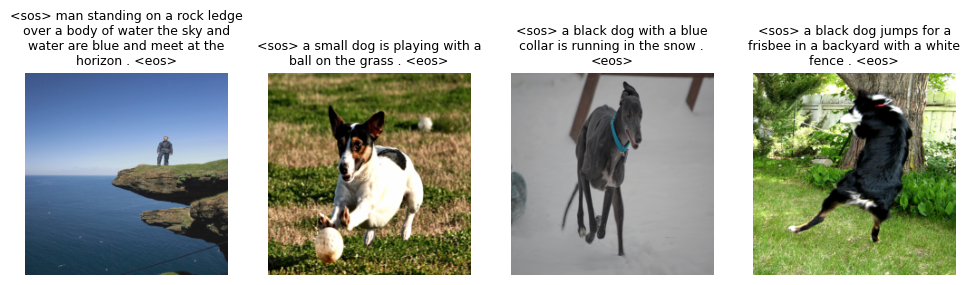

In [29]:
import random

import numpy as np

from textwrap import wrap

random.seed(0)


def denormalize(tensor, mean=NORM_MEAN, std=NORM_STD):
    """
    Denormalizes a tensor normalized by transforms.Normalize.

    Args:
        tensor (torch.Tensor): Normalized tensor.
        mean (list or tuple): Mean values used for normalization (one for each channel).
        std (list or tuple): Std values used for normalization (one for each channel).

    Returns:
        torch.Tensor: Denormalized tensor.
    """
    # Check if mean and std are single values, in case of grayscale images
    if not isinstance(mean, (list, tuple)):
        mean = [mean]
    if not isinstance(std, (list, tuple)):
        std = [std]

    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)

    return tensor * std + mean


def decode_caption(caption: torch.Tensor, vocab: torchtext.vocab.Vocab):
    words = [vocab.get_itos()[token] for token in caption.tolist()]
    return " ".join(words)


def visualize_dataset(ds: Dataset, wanted_images=4):
    f, axs = plt.subplots(1, wanted_images)
    f.set_figwidth(3 * wanted_images)
    sample_ids = random.sample(list(range(len(ds))), k=wanted_images)
    for i, sample_id in enumerate(sample_ids):
        image_tensor, caption = ds[sample_id]
        image = denormalize(image_tensor).numpy()
        image = np.transpose(image, (1, 2, 0))
        image[image > 1] = 1
        text = decode_caption(caption, ds.vocab)

        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title("\n".join(wrap(text, width=35)), fontsize=9)


visualize_dataset(train_dataset)

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.


In [62]:
def pad_caption(caption: torch.Tensor, target_length):
    padding_tensor = torch.tensor([VOCAB[PAD]] * (target_length - len(caption)))
    return torch.concat([caption, padding_tensor], dim=0)


def collate_fn(batch):
    """Custom collation function to pad captions in a single batch so that they have the same length."""

    images = torch.stack([pair[0] for pair in batch])
    raw_captions = [pair[1] for pair in batch]
    max_caption_length = max(map(len, raw_captions))

    padded_captions = [pad_caption(c, max_caption_length) for c in raw_captions]

    return (images, torch.stack(padded_captions))


common_dataloader_kwargs = {
    "batch_size": 16,
    "num_workers": 4,
    "pin_memory": True,
    "collate_fn": collate_fn,
}


train_loader = DataLoader(train_dataset, shuffle=True, **common_dataloader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **common_dataloader_kwargs)
test_loader = DataLoader(test_dataset, shuffle=False, **common_dataloader_kwargs)

#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.


In [6]:
# Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
assert False

AssertionError: 

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:

- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:

- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.


#### Reference

Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [ ]:
# ADD YOUR CODE HERE
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)  # generous hint
        pass

    def forward(self, images):  # generous hint
        pass
        return features

In [ ]:
# ADD YOUR CODE HERE
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):  # generous hint
        super(Attention, self).__init__()
        pass

    def forward(self, features, hidden_state):  # generous hint
        pass
        return context, weights  # generous hint

In [ ]:
# ADD YOUR CODE HERE
class Decoder(nn.Module):
    def __init__(
        self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim
    ):  # generous hint
        pass

    def forward(self, features, captions):  # generous hint
        pass

Combine the encoder - attention - decoder


In [ ]:
# ADD YOUR CODE HERE

### 2.2. Training custom model


### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation


In [ ]:
# ADD YOUR CODE HERE
# Example of how to save a model (call this in the training loop)
def save_model(model, num_epochs):
    model_state = {
        "embed_size": embed_size,
        "attention_dim": attention_dim,
        "encoder_dim": encoder_dim,
        "decoder_dim": decoder_dim,
        "state_dict": model.state_dict(),
    }

    torch.save(model_state, "image_captioning.pth")


# In case of resuming training, make sure to load the architecture first
# model = Architecture()
# and then load the weights and other params
# model.load_state_dict(model_state['state_dict'])

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.


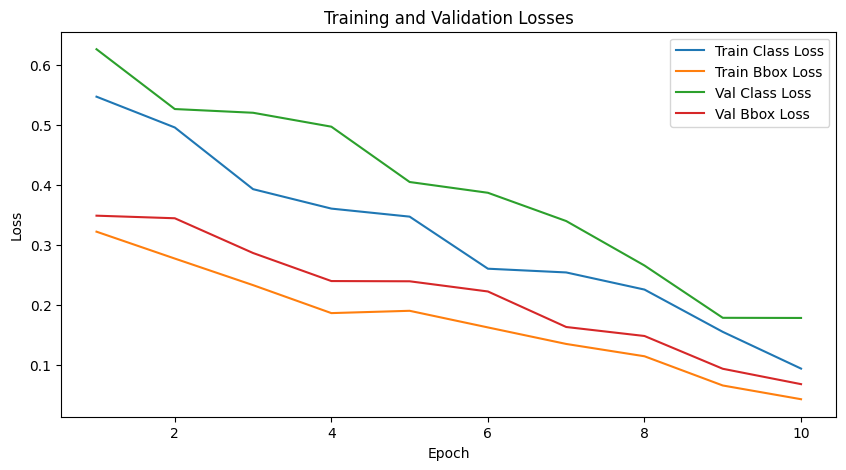

In [ ]:
# ADD YOUR CODE HERE

train_losses, val_losses = train_model(...)
plot_losses(train_losses, val_losses)
# DO NOT TRY TO REPLICATE... this is an example

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


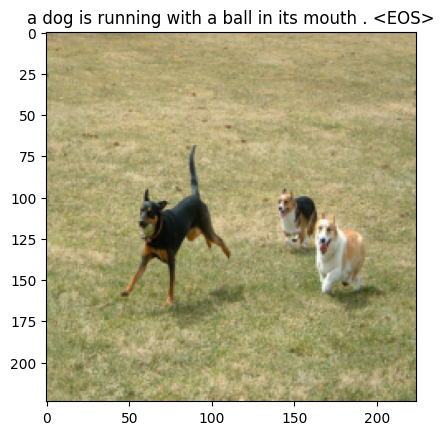

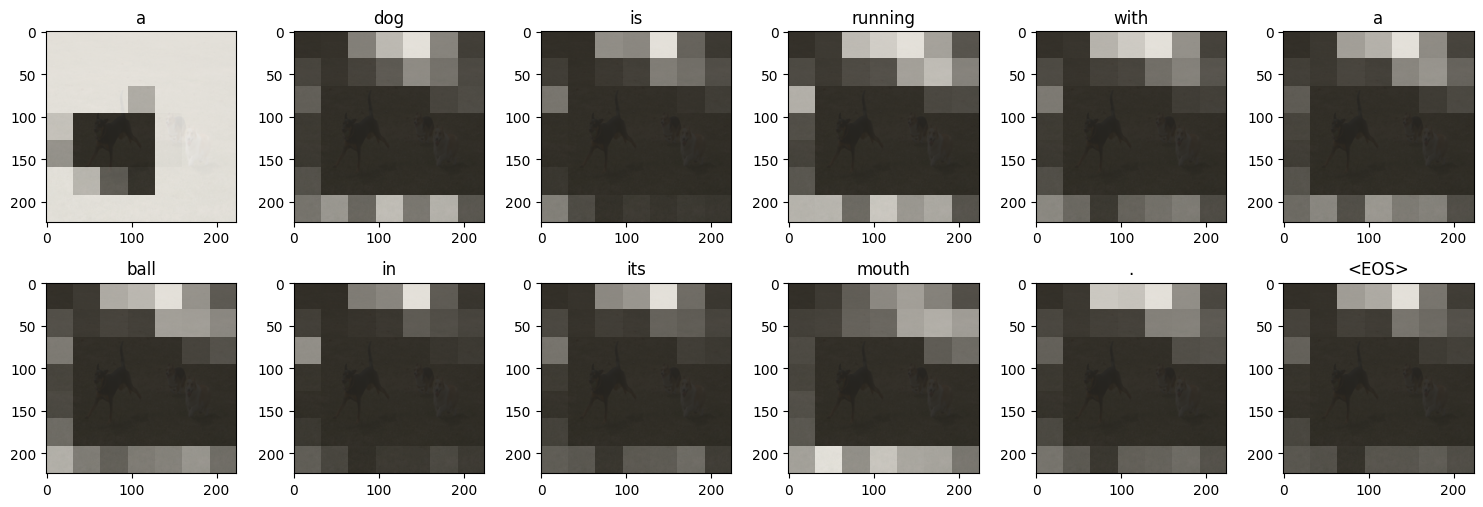

In [ ]:
# ADD YOUR CODE HERE

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.


In [ ]:
# ADD YOUR CODE HERE

### 2.4. Load an existing Image Captioning model

Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.


In [ ]:
# ADD YOUR CODE HERE

### 2.5 Evaluate the chosen pre-trained captioning model on the test set

Use the same metrics chosen on step **2.3**.


In [ ]:
# ADD YOUR CODE HERE

# 3. COMPARISON

Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?


In [ ]:
# ADD YOUR CODE HERE